In [1]:
from IPython.core.display import display, HTML
from matplotlib import pyplot, rcParams

display(HTML("<style>.container { width:108ch !important; }</style>"))

**First, let's create some data to play with.**

We will use scipy structured arrays, [described here](https://docs.scipy.org/doc/numpy/user/basics.rec.html).

[Downoad notebook from](https://github.com/kpenev/REUpython/raw/master/Least%20Squares%20Fitting.ipynb)

[Download test data file](https://github.com/kpenev/REUpython/raw/master/fitting_demo_data.csv)

Basically, tables multiple columns. Each column has a name and a type.

We will set-up a polynomial dependence and a broken powerlaw dependence.

In [28]:
import scipy

data = scipy.empty(100,
                   dtype=[('name', 'S10'),
                          ('x', float),
                          ('y', float),
                          ('z', float)])

data['name'] = ['object%02d' % i for i in range(100)]
data['x'] = scipy.random.uniform(0.0, 10.0, 100)
data['y'] = (0.3
             +
             1.0 * data['x']
             +
             0.1 * data['x']**2
             +
             0.1 * data['x']**3
             +
             scipy.random.normal(0.0, 3.0, 100))

break_x = 5.0
below_break = data['x'] < break_x
above_break = scipy.logical_not(below_break)
data['z'][below_break] = (data['x'][below_break] / break_x)**1.5
data['z'][above_break] = (data['x'][above_break] / break_x)**4
data['z'] *= 10.0**scipy.random.normal(0.0, 0.1, 100)

**Here is how this looks:**

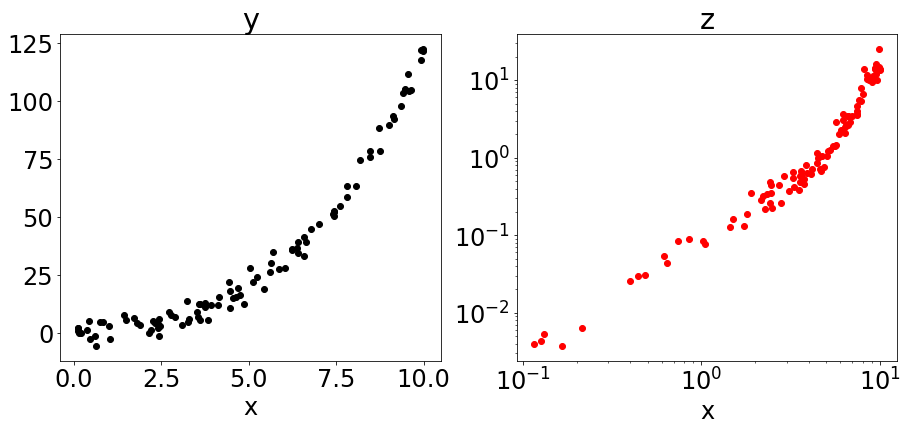

In [29]:
import matplotlib
from matplotlib import pyplot

def setup_readable_plots():
    """Configure matplotlib to create readable plots."""
    
    matplotlib.rc('figure', figsize=(15,6))
    matplotlib.rc('font', size=24)

setup_readable_plots()

pyplot.subplot(1, 2, 1)
pyplot.plot(data['x'], data['y'], 'ok')
pyplot.xlabel('x')
pyplot.title('y')

pyplot.subplot(1, 2, 2)
pyplot.loglog(data['x'], data['z'], 'or')
pyplot.xlabel('x')
pyplot.title('z');

Let's save this to a file.

We will use `savetxt`, [documented here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html).

In [30]:
column_names = (len(data.dtype.names) * '%12.12s ') % data.dtype.names

scipy.savetxt('fitting_demo_data.csv',
              data,
              fmt=b'%12.12s %12.6f %12.6f %12.6f',
              header=column_names[2:])

Getting Data Into Your Code
=======================

There are numerous data formats (CSV, FITS, HDF5, ...), we will only consider CSV (comma separated values), more accurately <anything\>SV.

Read data using `genfromtxt`: [documented here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html)

In [31]:
import scipy

data = scipy.genfromtxt('fitting_demo_data.csv',
                        names=True,
                        dtype=None,
                        encoding=None)

**Let's check that we got back what we put in!**

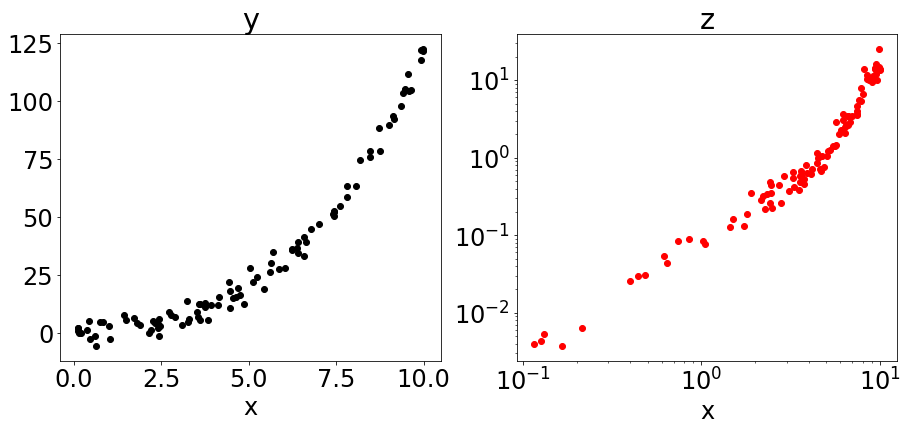

In [32]:
pyplot.subplot(1, 2, 1)
pyplot.plot(data['x'], data['y'], 'ok')
pyplot.xlabel('x')
pyplot.title('y')

pyplot.subplot(1, 2, 2)
pyplot.loglog(data['x'], data['z'], 'or')
pyplot.xlabel('x')
pyplot.title('z');

Linear Least Squares
=================

Note that **linear** refers to fit variables not `x`! In our case fitting `y` vs. `x` can be done as a linear fit!

In our case we need to find $c_i$ that minimize:

$
\left|
\left(
    \begin{array}{c c c c} 
        1 & x_0 & x_0^2 & x_0^3\\
        \vdots & \vdots & \vdots & \vdots\\
        1 & x_N & x_N^2 & x_N^3
    \end{array}
\right)
\left(\begin{array}{c} c_0 \\ c_1 \\ c_2 \\ c_3\end{array}\right)
-
\left(\begin{array}{c} y_0 \\ \vdots \\ y_N\end{array}\right)
\right|^2$ 

[Here is the documentation of the function we use](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html)

In [78]:
from scipy import linalg

matrix = scipy.empty((data['x'].size, 4))
for i in range(4):
    matrix[:, i] = data['x']**i
    
coefficients, residuals, rank, singular_values = linalg.lstsq(
    matrix,
    data['y']
)

Time to plot
----------------

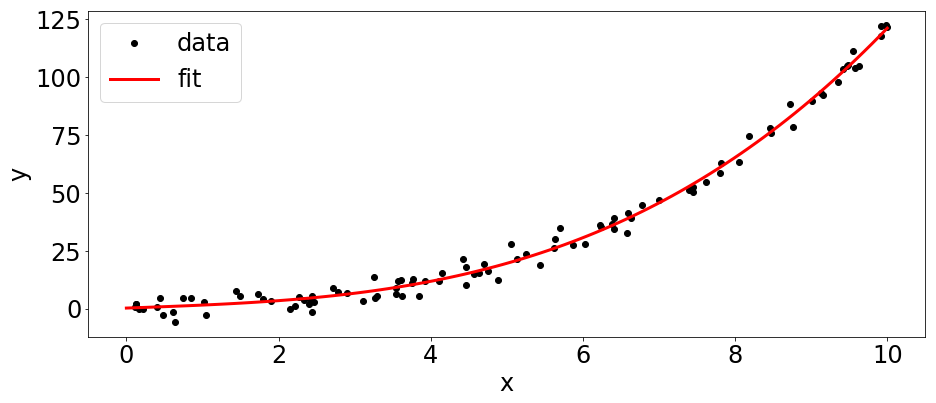

In [42]:
fit_plot_x = scipy.linspace(0, 10, 100)
fit_plot_y = scipy.zeros(fit_plot_x.shape)
for power, coef in enumerate(coefficients):
    fit_plot_y += coef * fit_plot_x**power

pyplot.plot(data['x'], data['y'], 'ok', label='data')
pyplot.plot(fit_plot_x, fit_plot_y, color='red', linewidth=3, label='fit')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.legend();

Non-linear least squares
====================

In fitting for $z(x)$ we want to allow both the powerlaw indices and the location of the break to vary.

**No longer a linear problem!**

[Here is the documentation of the function that does that](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html)

In [64]:
def broken_powerlaw_residuals(parameters):
    """
    Take a vector of fitting parameters and return the residual.
    
    Args:
        parameters (array of size 3):    The vector of parameters being fit.
            The first two entries are assumed to bet the powerlaw indices at
            small and large x respectively and the third entry is the
            location of the break.
            
    Returns:
        (array):
            The log of the ratio of the data to the model at each 'x'.
    """
    
    power_low, power_high, break_x = parameters
    
    below_break = data['x'] < break_x
    above_break = scipy.logical_not(below_break)
    model = scipy.empty(data['x'].shape)
    model[below_break] = (data['x'][below_break] / break_x)**power_low
    model[above_break] = (data['x'][above_break] / break_x)**power_high
    
    return scipy.log(data['z'] / model)

In [65]:
from scipy import optimize

power_below, power_above, break_x = optimize.leastsq(
    broken_powerlaw_residuals,
    (1.0, 1.0, 1.0)
)[0]

Time to plot
----------------

In [ ]:
xmin, xmax = data['x'].min(), data['x'].max()
model_x_below = (
    scipy.exp(scipy.linspace(scipy.log(xmin / break_x), 0, 100))
    *
    break_x
)
model_x_above = (
    scipy.exp(scipy.linspace(0, scipy.log(xmax / break_x), 100))
    *
    break_x
)

Text(0,0.5,'z')

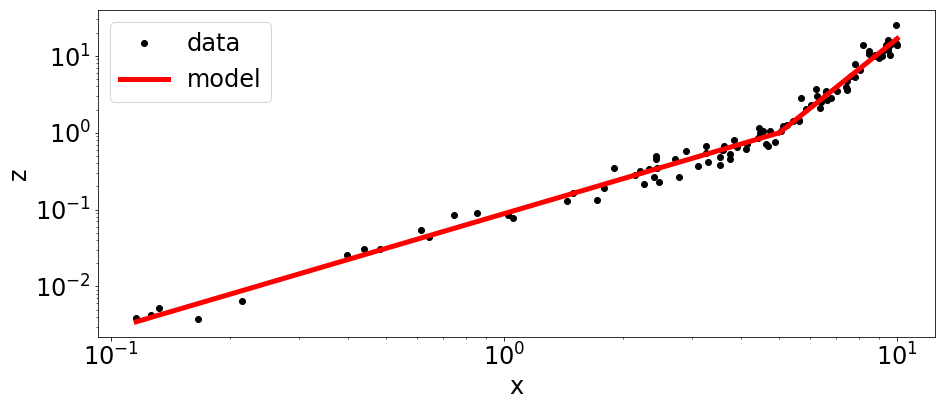

In [77]:
pyplot.loglog(data['x'], data['z'], 'ok', label='data')
pyplot.loglog(model_x_below,
              (model_x_below / break_x)**power_below,
              '-r',
              linewidth=5,
              label='model')
pyplot.loglog(model_x_above,
             (model_x_above / break_x)**power_above,
             '-r',
             linewidth=5)
pyplot.legend()
pyplot.xlabel('x')
pyplot.ylabel('z')